Sampling notebook, but using LiDAR images in Earth Engine instead of local, and with support for 2D LiDAR samples.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ee

from naip_cnn import sampling
from naip_cnn.config import CRS

# ee.Authenticate()
ee.Initialize()

In [3]:
MIN_SPACING = 150
PROJ = ee.Projection(CRS)

In [91]:
# For 2007, the closest NAIP are 2006 (RGB) and 2009 (RGBNIR)
lidar = ee.Image("projects/ee-maptheforests/assets/malheur_lidar/MAL2016_CanyonCreek").reproject(PROJ.atScale(30))
naip = (ee.ImageCollection("USDA/NAIP/DOQQ")
    .filterDate("2016", "2017")
    .filterBounds(lidar.geometry().bounds())
    .mosaic()
    .reproject(PROJ.atScale(1))
)

In [92]:
samples = lidar.sample(scale=MIN_SPACING, projection=PROJ, factor=1.0, dropNulls=True, geometries=True)
footprints = samples.map(lambda p: sampling._create_footprint_at_point(p, dims=(150, 150), proj=PROJ))

footprints = footprints.map(lambda f: sampling._extract_values_at_footprint(f, img=lidar, proj=PROJ, scale=30), opt_dropNulls=True)
footprints = footprints.map(lambda f: sampling._extract_values_at_footprint(f, img=naip, proj=PROJ, scale=1), opt_dropNulls=True)

In [6]:
task = ee.batch.Export.table.toDrive(
    collection=footprints,
    description="MAL2016_CanyonCreek_150x150",
)

task.start()

# TODO

- Test my footprint extraction with one or two clear examples just to 100% confirm I'm getting the right values
- Iterate over every LiDAR dataset and sample from it and the corresponding NAIP dataset
    - Need to decide how to handle years with no NAIP and may need to deal with different bands
- Modify (and rename) `extract_footprints_from_dataframe` to work from a FeatureCollection instead of a dataframe

In [41]:
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt

In [51]:
df = pd.read_csv("../data/training/MAL2016_CanyonCreek_150x150.csv")

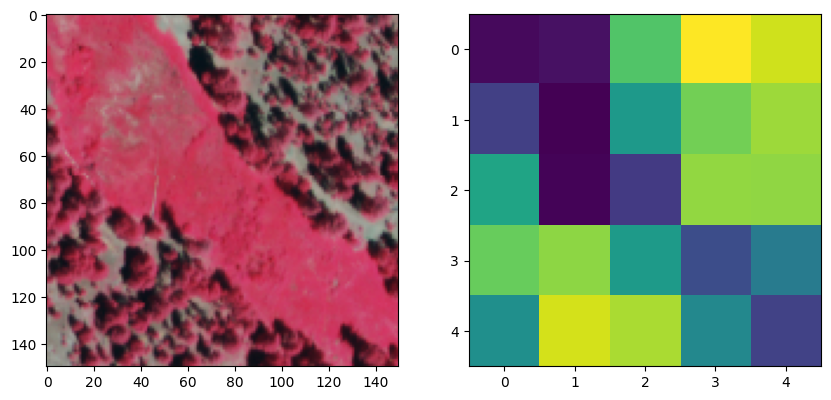

In [78]:
row = df.loc[2000]

n = json.loads(row.N)
r = json.loads(row.R)
g = json.loads(row.G)
b = json.loads(row.B)

# The swapaxes and flip are weird, but I confirmed they're correct.
naip_array = np.stack([n, r, g]).reshape(3, 150, 150).swapaxes(0, 2).swapaxes(0, 1)[::-1, ...]
lidar_array = np.array(json.loads(row.cover)).reshape(5, 5)[::-1, ...]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(naip_array)
ax[1].imshow(lidar_array)